## December 2022 demo - MIRA, TA2

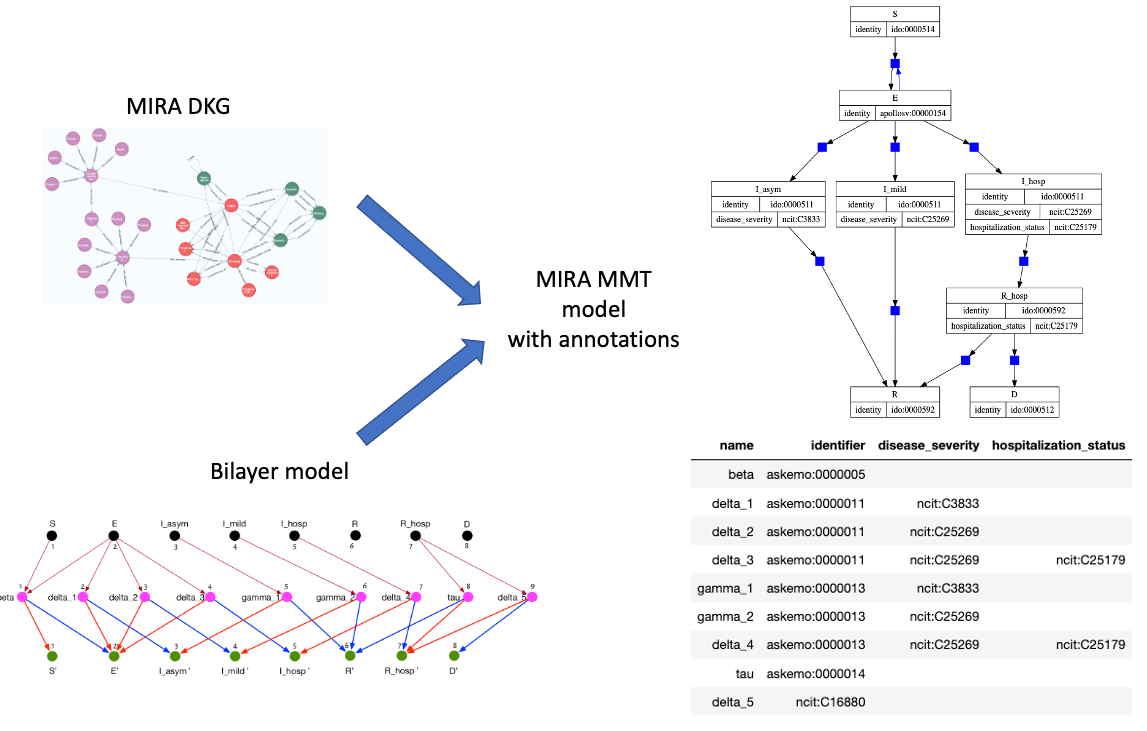

### What we demo here
- **Model comparison** across CHIME-SIR, CHIME-SVIIVR, Bucky and SIDARTHE (BIOMD0000000955)
- **Model search using domain concepts**: find models that contain e.g., vaccination

### New modeling features
- **Generalized rate laws**: faithfully represent/propagate custom rate laws from original model
- **Grounded parameters**: represent identifiers for each model parameter allowing for referencing them (e.g., for interventions)
- **Initial condition and parameter values**: propagate original initial conditions and parameter values

In [44]:
from IPython.display import Image
from mira.metamodel import model_from_json_file
from mira.sources import biomodels, sbml
from mira.metamodel import TemplateModelDelta
from mira.dkg.web_client import is_ontological_child
from mira.metamodel.templates import get_dkg_refinement_closure

refinement_fun = get_dkg_refinement_closure().is_ontological_child

We load the Bucky, CHIME-SIR and CHIME-SVIIvR models based on the TA1-constructed bilayers combined with
MIRA annotations.

In [45]:
model_prefixes = {'bucky': 'Bucky_SEIIIRRD_BiLayer',
                  'chime_sir': 'CHIME_SIR_dynamics_BiLayer',
                  'chime_sviivr': 'CHIME_SVIIvR_dynamics_BiLayer'}

In [46]:
models = {model_name: model_from_json_file(f'{fname_prefix}_mira.json')
          for model_name, fname_prefix in model_prefixes.items()}

We extract the SIDARTHE model from SBML.

In [47]:
models['sidarthe'] = sbml.template_model_from_sbml_file('/Users/ben/.data/mira/biomodels/models/BIOMD0000000955/BIOMD0000000955.xml')

# Comparing the CHIME SIR and CHIME SVIIVR models
Interpretation:
- S and V in SVIIVR are refinements of S in SIR
- I and Iv in SVIIVR are refinements of I in SIR
- The vaccine-status-specific infection processes in SVIIVR are refinements of the infection process in SIR
- The vaccine-status-specific recovery processes in SVIIVR are refinements of the recovery process in SIR
- Recovered individuals are exactly the same between the two models

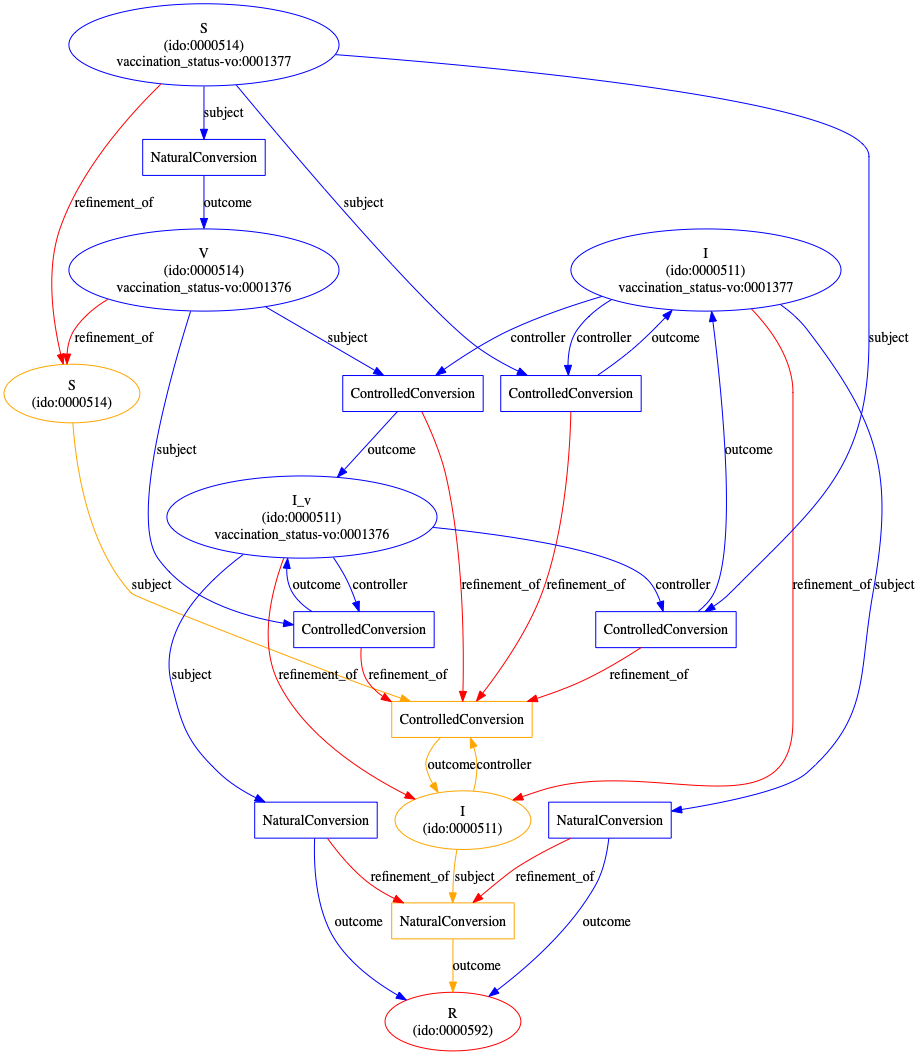

In [48]:
td = TemplateModelDelta(models['chime_sir'], models['chime_sviivr'], refinement_fun)
td.draw_graph('comparison.png', args='-Grankdir=TB')
Image('comparison.png')

## Comparing the Bucky and CHIME SIR models
Interpretation:
- S is the same across both models but Bucky has separate E state that CHIME doesn't have
- Subpopulations of infected (I_asym, I_mild, I_hosp) in Bucky are refinements of I in CHIME
- Three recovery processes in Bucky are refinements of single recovery process in CHIME
- Only Bucky contains the D (deceased) state

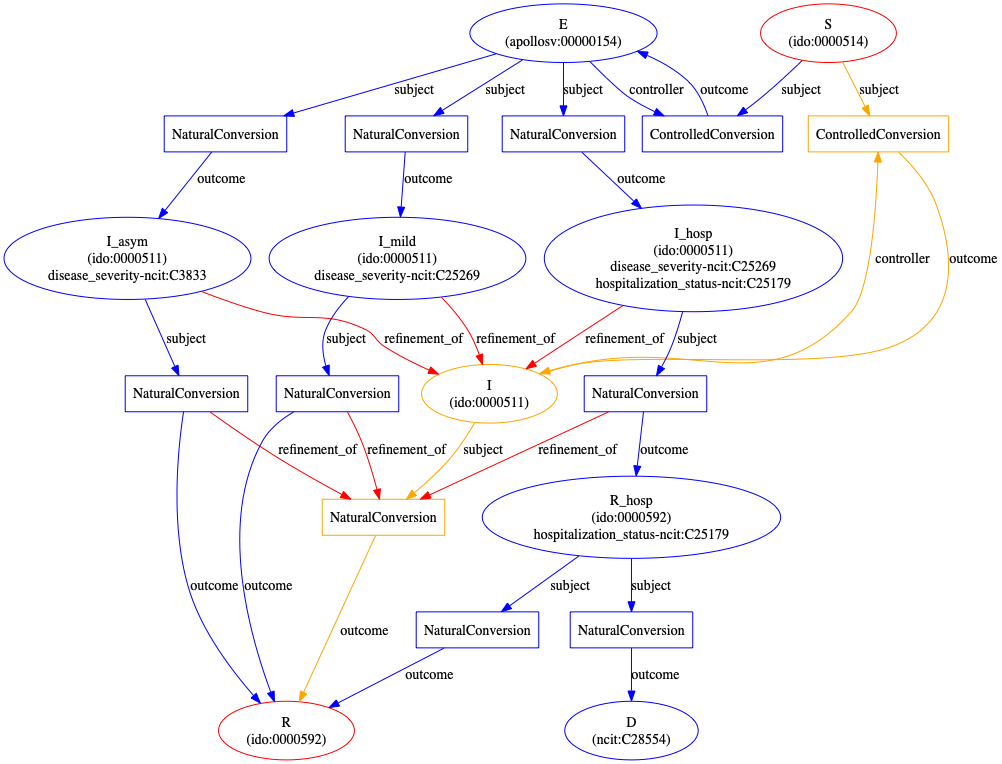

In [49]:
td = TemplateModelDelta(models['chime_sir'], models['bucky'], refinement_fun)
td.draw_graph('comparison.png', args='-Grankdir=TB')
Image('comparison.png')

## Comparing CHIME SIR and SIDARTHE
Interpretation:
- Susceptible is the same in both models
- I, D, A, R, T are all refinements of Infected in CHIME SIR
- Healed in SIDARTHE is the same as Recovered in CHIME SIR
- Extinct (deceased) is only present in the SIDARTHE model

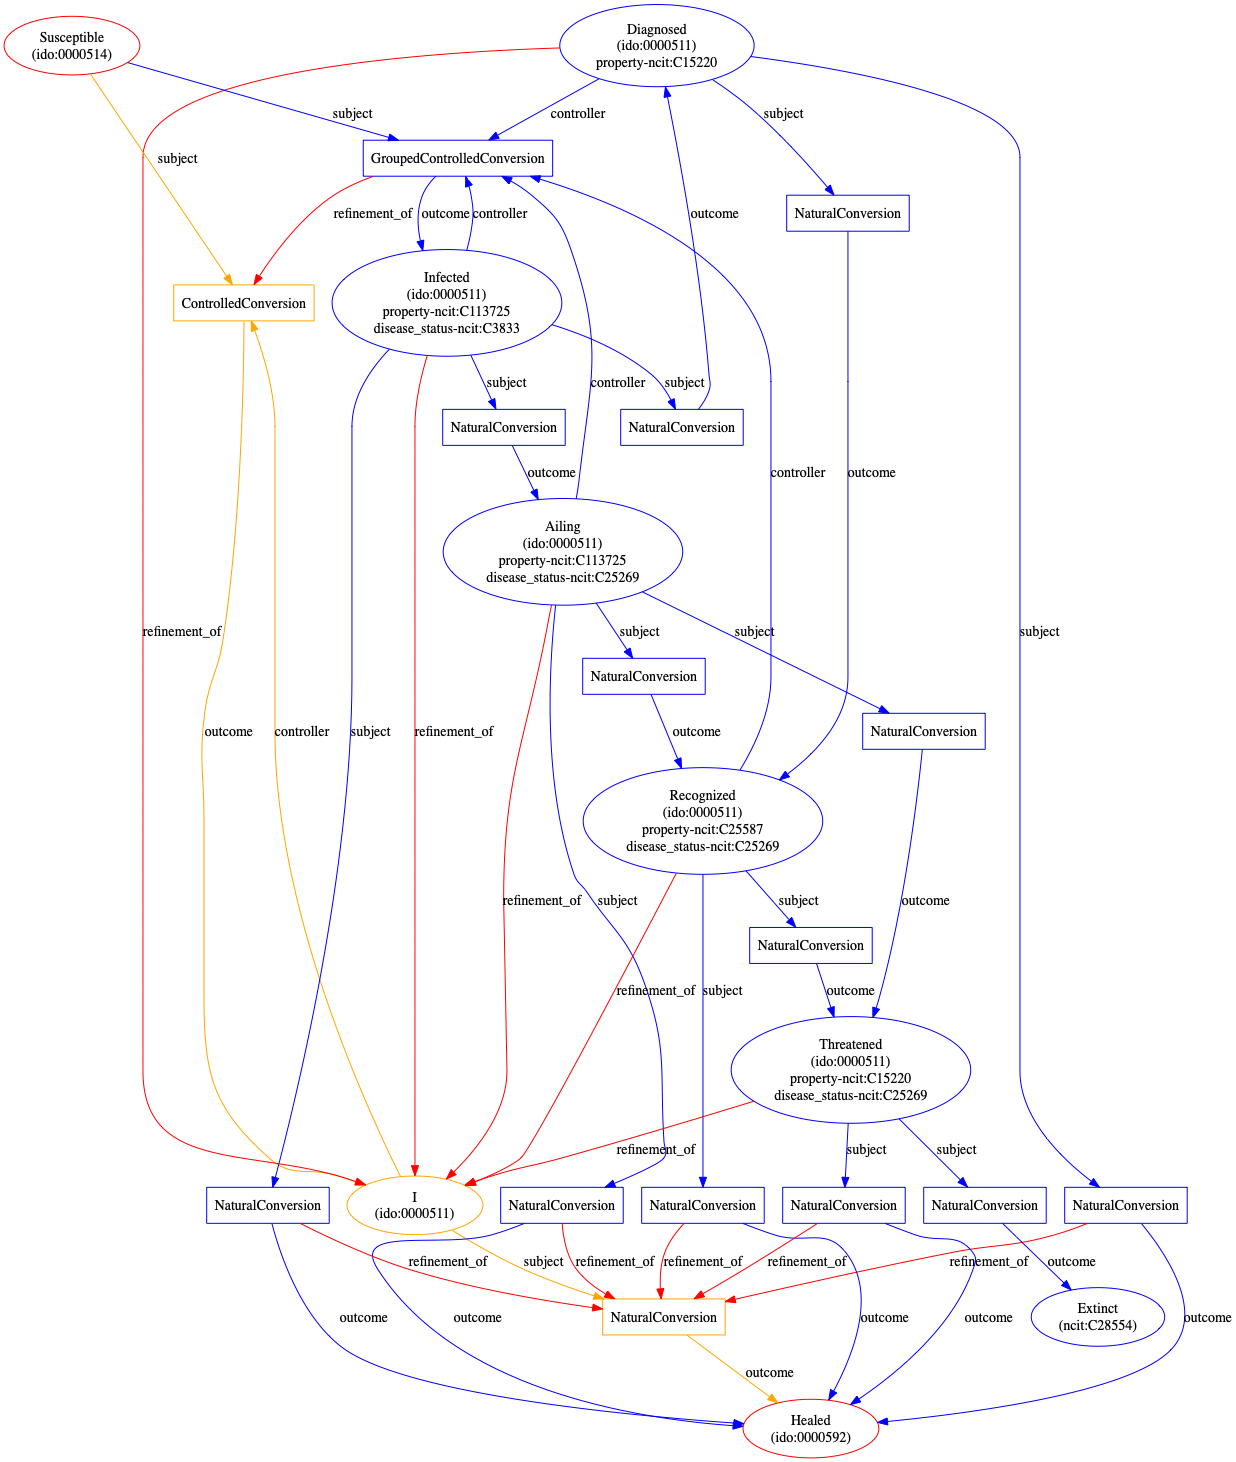

In [50]:
td = TemplateModelDelta(models['chime_sir'], models['sidarthe'], refinement_fun)
td.draw_graph('comparison.png', args='-Grankdir=TB')
Image('comparison.png')

In [51]:
from mira.metamodel.ops import model_has_grounding, find_models_with_grounding

### Find models with vaccination

In [52]:
res = find_models_with_grounding(models, 'vo', '0001376')  # Term for "vaccinated"
print(sorted(res.keys()))

['chime_sviivr']


### Find models with hospitalization

In [53]:
res = find_models_with_grounding(models, 'ncit', 'C25179')  # Term for "hospitalized"
print(sorted(res.keys()))

['bucky']


### Bring in all BioModels to expand search

In [54]:
import pystow, glob, os, tqdm

base_folder = pystow.join('mira', 'biomodels', 'models')
fnames = glob.glob(os.path.join(base_folder.as_posix(),
                                'BIOMD*/BIOMD*.xml'))
for fname in tqdm.tqdm(fnames):
    tm = sbml.template_model_from_sbml_file(fname)
    models[os.path.splitext(os.path.basename(fname))[0]] = tm

100%|██████████| 22/22 [00:01<00:00, 18.49it/s]


In [55]:
res = find_models_with_grounding(models, 'ncit', 'C25179')  # Term for "hospitalized"
print(sorted(res.keys()))

['BIOMD0000000969', 'BIOMD0000000971', 'BIOMD0000000972', 'BIOMD0000000981', 'bucky']


## New model representation features
**Detailed rate laws**

In [37]:
print(models['sidarthe'].templates[0].rate_law)

1.0*Susceptible*(Ailing*gamma + Diagnosed*beta + Infected*alpha + Recognized*delta)


In [40]:
print(models['BIOMD0000000971'].templates[0].rate_law)

1.0*Susceptible*beta*c*(1.0 - q)*(Asymptomatic*theta + Infected)


**Parameter values and annotations**

In [41]:
print(models['bucky'].parameters['delta_4'].json())

{"name": "delta_4", "identifiers": {"askemo": "0000013"}, "context": {"disease_severity": "ncit:C25269", "hospitalization_status": "ncit:C25179"}, "value": 1.0}


In [42]:
print(models['sidarthe'].parameters['beta'].json())

{"name": "beta", "identifiers": {}, "context": {}, "value": 0.011}


**Initial conditions**

In [43]:
print(models['sidarthe'].initials['Susceptible'])

concept=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}) value=0.9999963
